<a href="https://colab.research.google.com/github/gayecolakoglu/DiabeticRetinopathyDetection/blob/main/Bayesian_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 5.8 MB/s 
     |████████████████████████████████| 71 kB 2.6 MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp37-cp37m-linux_x86_64.whl size=2619358 sha256=fab091a810f5071757ea873215774d23fcd9df305720c1be54e13aa3368bf712
  Stored in directory: /root/.cache/pip/wheels/23/6d/58/90d8e44f8fd9f442de81992a427a5947a6e5f7b78cd65acd9a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=cf439ee5a6dd190fef3e30994b4b637f7e420315187c6c08be13efcf1a49e472
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.0 MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.1-py3-none-any.whl size=73656 sha

In [3]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/KaggleImageData/UfukHocaVeri', output="output", seed=1337, ratio=(.7, 0.2,0.1)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 193 files [00:42,  4.55 files/s]


In [4]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'val']) # Görselleri dataframe'e yazar target'la birlikte. Görselleri array olarak tutar.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Görselleri normalize eder (x = x / 255) targetlara da one hot encoding yapar (1,0,0)
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = tf.keras.applications.vgg16.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [6]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout

input_tensor = K.Input(shape=(32, 32, 3)) # Input olarak girecek yapıyı oluşturur
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor) # lambda list comp. gibi input_tensordaki tüm image'ı resize ediyor
base_model = VGG16(include_top=False,
                    weights='imagenet',
                    input_tensor=resized_images,
                    input_shape=(224, 224, 3),
                    pooling='max',
                    classes=5)

output = base_model.layers[-1].output # Denenecek
base_model = K.models.Model(inputs=input_tensor, outputs=output) # No idea

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        rotation_range=40,
                                                        width_shift_range=0.2,
                                                        height_shift_range=0.2,
                                                        zoom_range=0.2,
                                                        shear_range=0.2,
                                                        horizontal_flip=True,
                                                        fill_mode='nearest')# with data augmentation for train set
      
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

In [9]:
from tensorflow.keras import layers, models
from keras.models import Sequential, Model

def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch = 32, optim=1):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=5,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  if optim==1:
    model.compile(
            optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  elif optim==2:
    model.compile(
            optimizer=K.optimizers.SGD(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  elif optim==3:
    model.compile(
            optimizer=K.optimizers.RMSprop(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  else:
    print("Wrong optimizer!!")
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('VGG_16.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [10]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=100,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [11]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.32432, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.32432

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.32432

Epoch 4: val_accuracy did not improve from 0.32432
Epoch 4: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 27.0375 - accuracy: 0.2432

LOSS:	27.03748893737793 	 ACCURACY:	0.2432432472705841
[27.03748893737793, 0.2432432472705841]



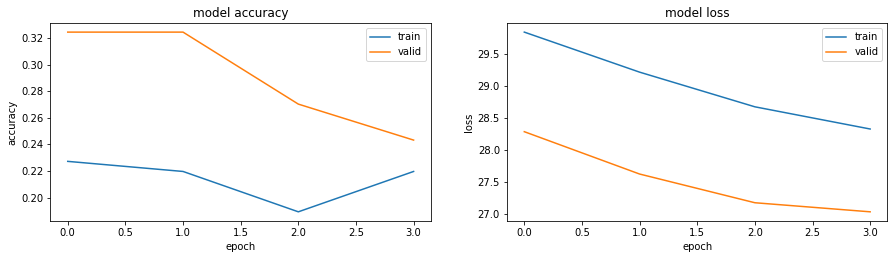


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 3.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 27.0375 - accuracy: 0.2432

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27027 to 0.37838, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.37838 to 0.43243, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.43243

Epoch 6: val_accuracy did not improve from 0.43243
Epoch 6: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 27.8225 - accuracy: 0.4054

LOSS:	27.822532653808594 	 ACCURACY:	0.4054054021835327
[27.822532653808594, 0.4054054021835327]



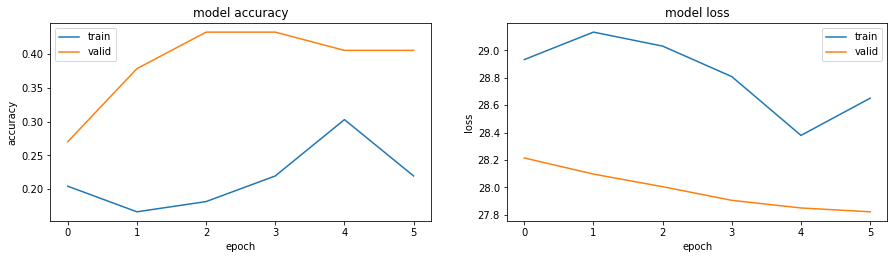


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 3.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 27.8225 - accuracy: 0.4054

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 2.6340 - accuracy: 0.4054

LOSS:	2.6339519023895264 	 ACCURACY:	0.4054054021835327
[2.6339519023895264, 0.4054054021835327]



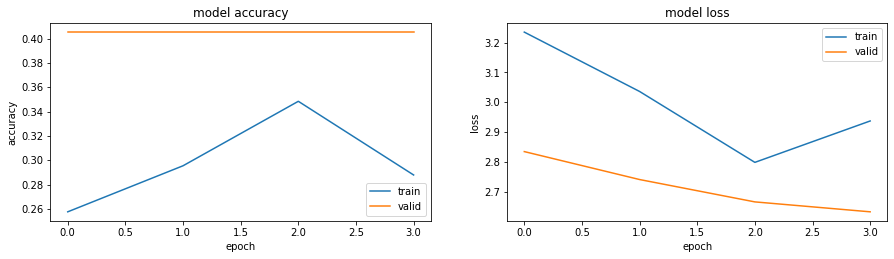


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-01 2.0e+00 5.0e-01 3.2e+01 1.0e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 27.8225 - accuracy: 0.4054

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 15.6987 - accuracy: 0.2432

LOSS:	15.698667526245117 	 ACCURACY:	0.2432432472705841
[15.698667526245117, 0.2432432472705841]



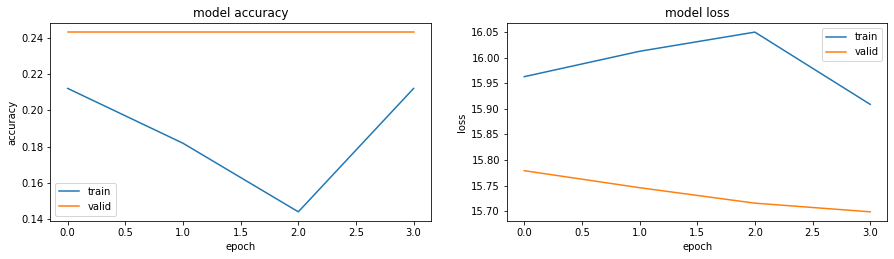


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 3.00e+00 3.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 27.8225 - accuracy: 0.4054

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 54.4441 - accuracy: 0.1351

LOSS:	54.44407272338867 	 ACCURACY:	0.13513512909412384
[54.44407272338867, 0.13513512909412384]



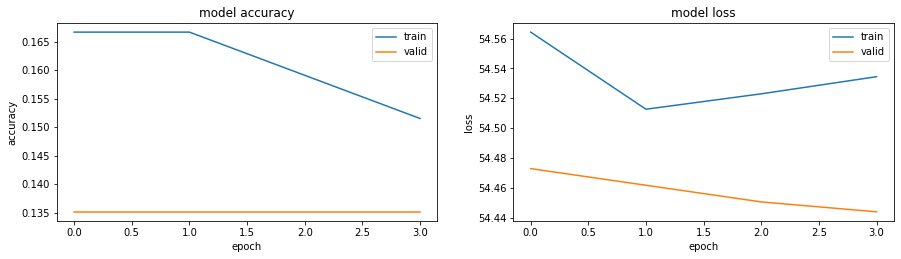




Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 2.00e+00 7.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 27.8225 - accuracy: 0.4054

Epoch 1: val_accuracy improved from -inf to 0.48649, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.48649

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.48649

Epoch 4: val_accuracy did not improve from 0.48649
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 11.8792 - accuracy: 0.4595

LOSS:	11.879195213317871 	 ACCURACY:	0.45945945382118225
[11.879195213317871, 0.45945945382118225]



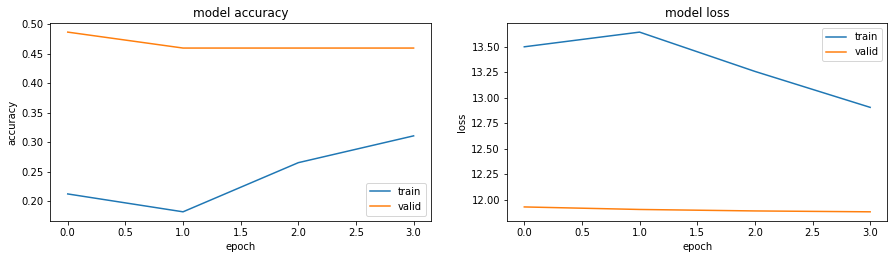


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 11.8792 - accuracy: 0.4595

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 14ms/step - loss: 3.2950 - accuracy: 0.1351

LOSS:	3.294985771179199 	 ACCURACY:	0.13513512909412384
[3.294985771179199, 0.13513512909412384]



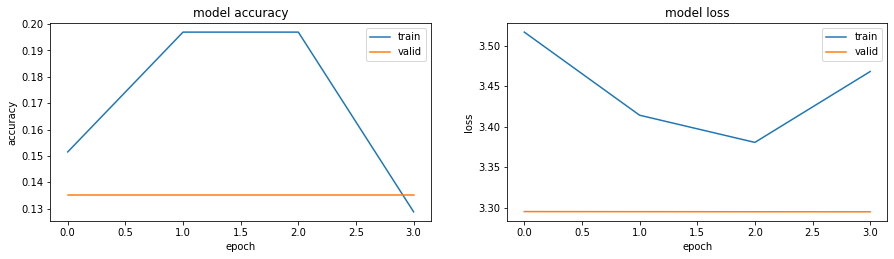


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 11.8792 - accuracy: 0.4595

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 42ms/step - loss: 13.5560 - accuracy: 0.1351

LOSS:	13.556032180786133 	 ACCURACY:	0.13513512909412384
[13.556032180786133, 0.13513512909412384]



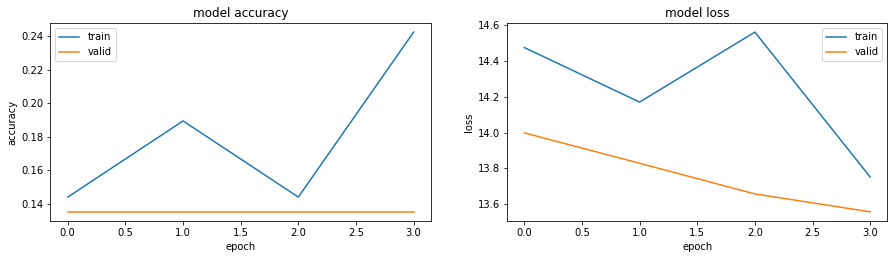


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 3.00e+00 3.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 11.8792 - accuracy: 0.4595

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.37838

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.37838

Epoch 4: val_accuracy did not improve from 0.37838
Epoch 4: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 1.9034 - accuracy: 0.3784

LOSS:	1.903428554534912 	 ACCURACY:	0.37837839126586914
[1.903428554534912, 0.37837839126586914]



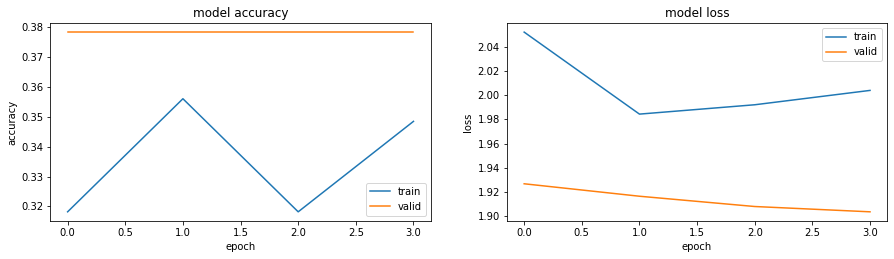


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 11.8792 - accuracy: 0.4595

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: val_accuracy improved from 0.08108 to 0.10811, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.10811

Epoch 5: val_accuracy improved from 0.10811 to 0.13514, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.13514 to 0.16216, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.16216 to 0.21622, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.21622 to 0.24324, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.24324 to 0.32432, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.32432

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 11: val_

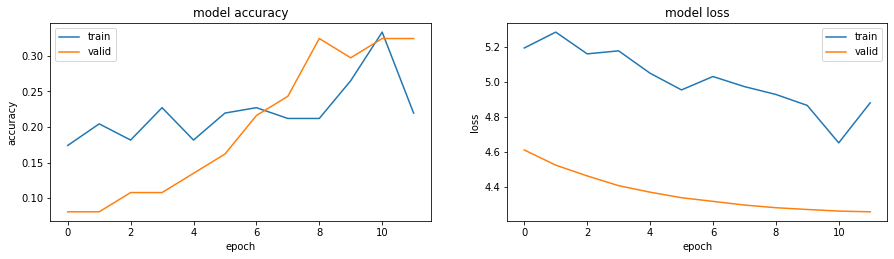


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 3.00e+00 3.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 14ms/step - loss: 11.8792 - accuracy: 0.4595

Epoch 1: val_accuracy improved from -inf to 0.32432, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.32432

Epoch 3: val_accuracy improved from 0.32432 to 0.35135, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.35135

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 5: val_accuracy did not improve from 0.35135

Epoch 6: val_accuracy did not improve from 0.35135
Epoch 6: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 1.8035 - accuracy: 0.2973

LOSS:	1.8034511804580688 	 ACCURACY:	0.29729729890823364
[1.8034511804580688, 0.29729729890823364]



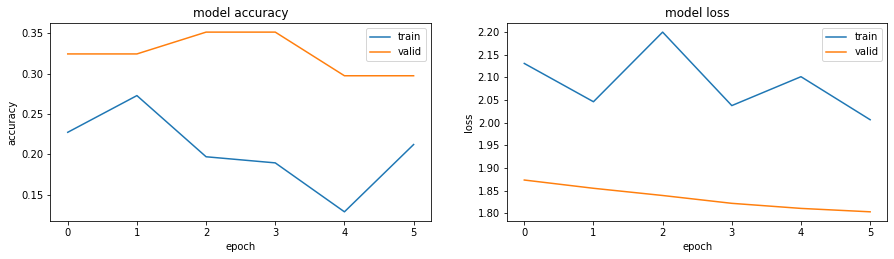


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 15ms/step - loss: 11.8792 - accuracy: 0.4595

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: val_accuracy improved from 0.40541 to 0.45946, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.48649

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.48649

Epoch 7: val_accuracy improved from 0.48649 to 0.51351, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.51351

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.51351

Epoch 10: val_accuracy improved from 0.51351 to 0.54054, saving model to VGG_16.h5



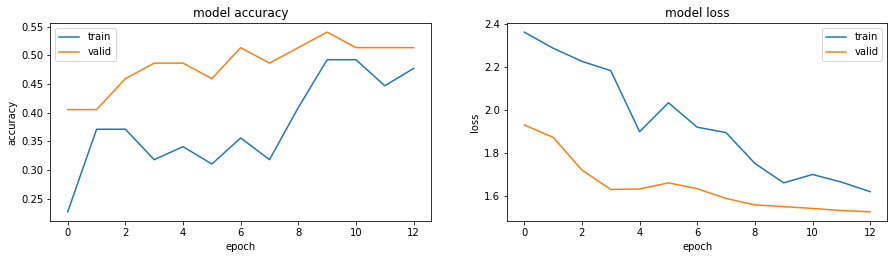


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 2.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 23ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.48649, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.48649

Epoch 3: val_accuracy improved from 0.48649 to 0.51351, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.51351

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.51351

Epoch 6: val_accuracy did not improve from 0.51351
Epoch 6: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 1.5763 - accuracy: 0.5135

LOSS:	1.5762704610824585 	 ACCURACY:	0.5135135054588318
[1.5762704610824585, 0.5135135054588318]



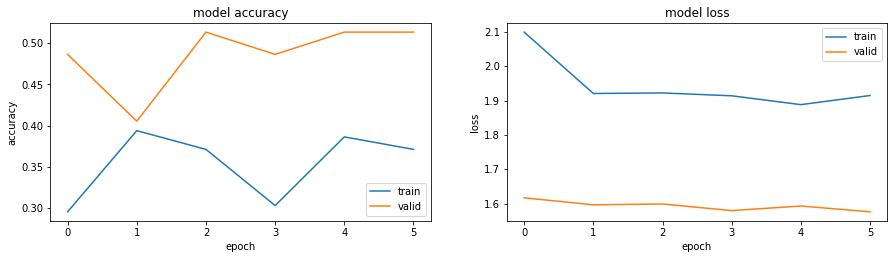


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 20ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 17ms/step - loss: 29.6611 - accuracy: 0.0811

LOSS:	29.661083221435547 	 ACCURACY:	0.0810810774564743
[29.661083221435547, 0.0810810774564743]



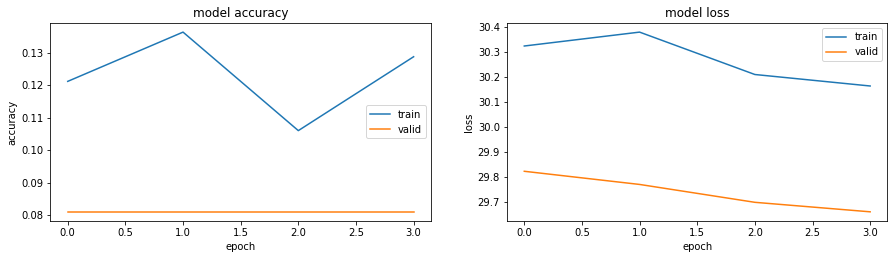


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.32432, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.32432 to 0.37838, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.40541

Epoch 6: val_accuracy did not improve from 0.40541
Epoch 6: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 1.9290 - accuracy: 0.4054

LOSS:	1.9290237426757812 	 ACCURACY:	0.4054054021835327
[1.9290237426757812, 0.4054054021835327]



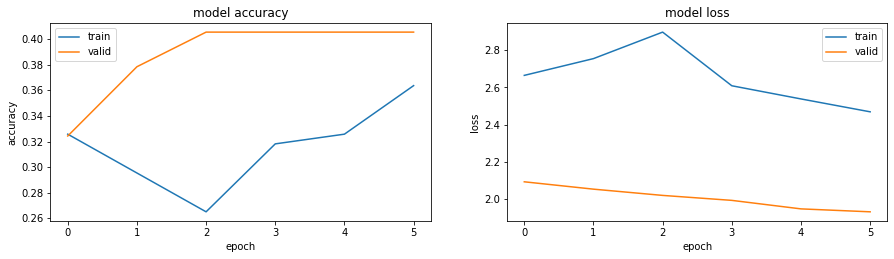


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 3.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 17ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: val_accuracy did not improve from 0.21622
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 4.4540 - accuracy: 0.2162

LOSS:	4.453973770141602 	 ACCURACY:	0.21621622145175934
[4.453973770141602, 0.21621622145175934]



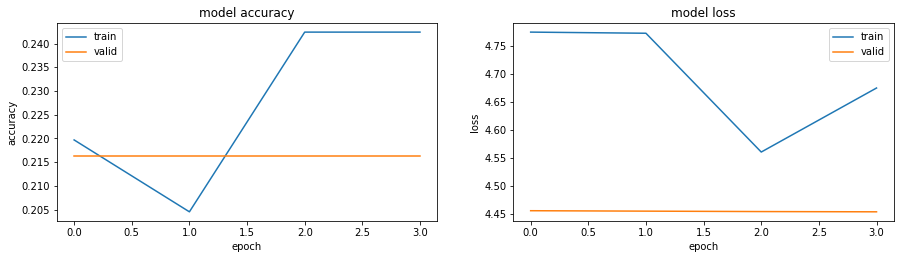


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 3.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 14ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.45946, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.45946

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.45946

Epoch 4: val_accuracy did not improve from 0.45946
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 17.7895 - accuracy: 0.4595

LOSS:	17.789520263671875 	 ACCURACY:	0.45945945382118225
[17.789520263671875, 0.45945945382118225]



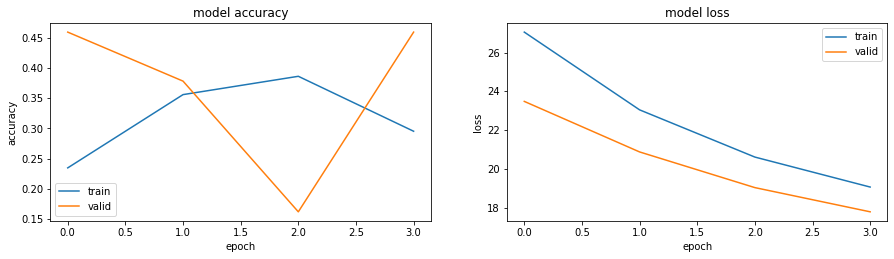


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 16ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: val_accuracy improved from 0.21622 to 0.32432, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.32432 to 0.40541, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.40541

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.40541

Epoch 7: val_accuracy did not improve from 0.40541
Epoch 7: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 3.9896 - accuracy: 0.4054

LOSS:	3.9895901679992676 	 ACCURACY:	0.4054054021835327
[3.9895901679992676, 0.4054054021835327]



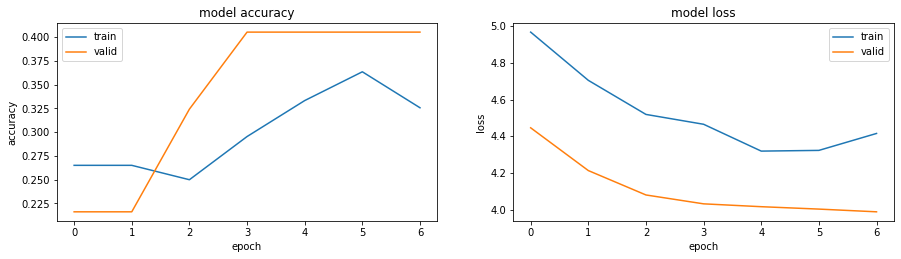


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-02 1.00e+00 3.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 4.2335 - accuracy: 0.2162

LOSS:	4.2335357666015625 	 ACCURACY:	0.21621622145175934
[4.2335357666015625, 0.21621622145175934]



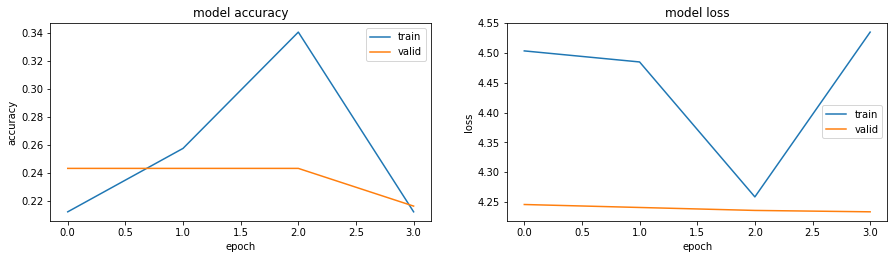


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 29.0336 - accuracy: 0.0811

LOSS:	29.033599853515625 	 ACCURACY:	0.0810810774564743
[29.033599853515625, 0.0810810774564743]



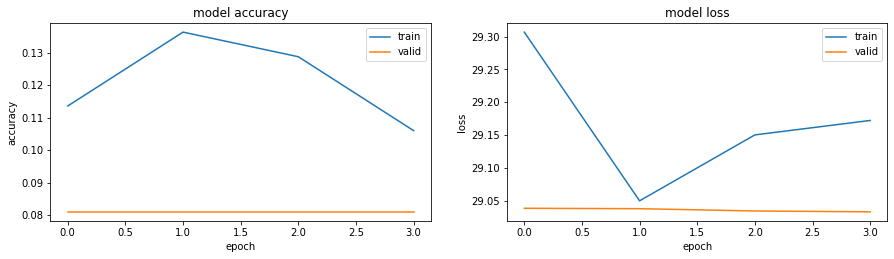


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 24.7372 - accuracy: 0.1622

LOSS:	24.737218856811523 	 ACCURACY:	0.1621621549129486
[24.737218856811523, 0.1621621549129486]



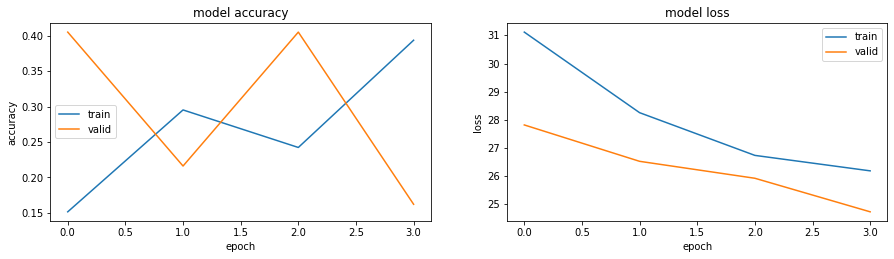


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27027 to 0.29730, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.29730

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.29730

Epoch 5: val_accuracy did not improve from 0.29730
Epoch 5: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 4.2070 - accuracy: 0.2432

LOSS:	4.207047939300537 	 ACCURACY:	0.2432432472705841
[4.207047939300537, 0.2432432472705841]



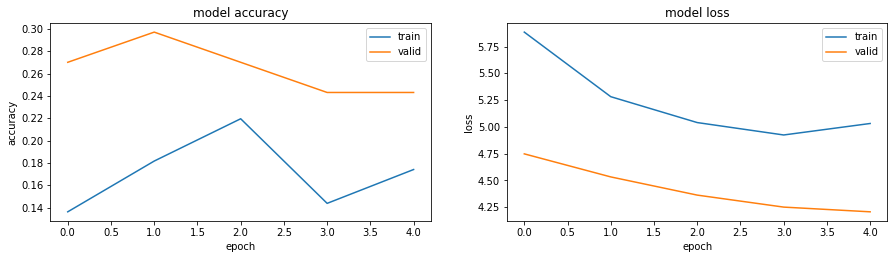


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 14ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 3.6840 - accuracy: 0.4054

LOSS:	3.6840198040008545 	 ACCURACY:	0.4054054021835327
[3.6840198040008545, 0.4054054021835327]



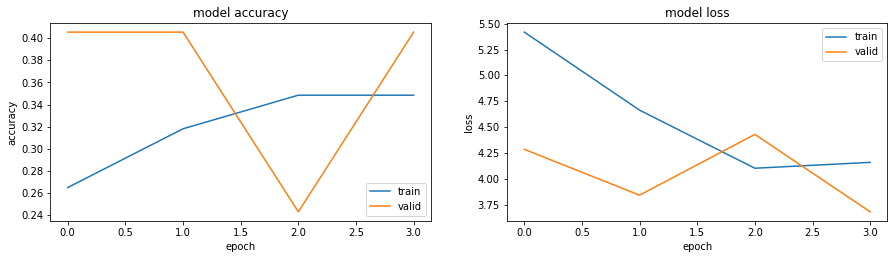


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 2.2695 - accuracy: 0.1081

LOSS:	2.2694520950317383 	 ACCURACY:	0.10810811072587967
[2.2694520950317383, 0.10810811072587967]



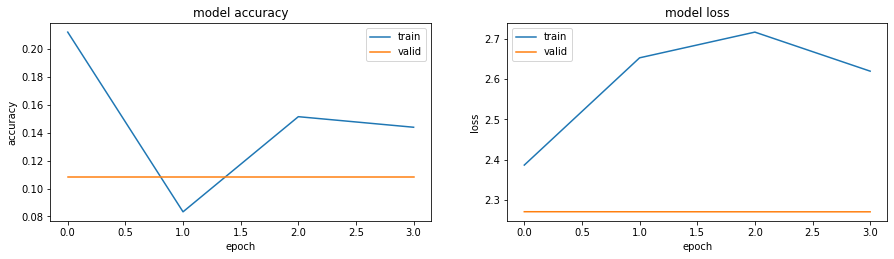


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 3.5952 - accuracy: 0.1892

LOSS:	3.5952353477478027 	 ACCURACY:	0.18918919563293457
[3.5952353477478027, 0.18918919563293457]



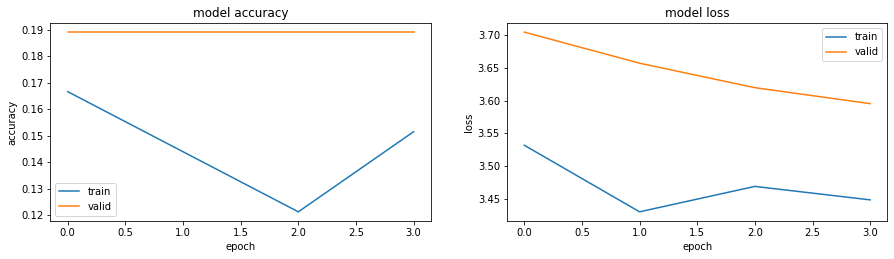


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 2.00e+00 3.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 18ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.24324 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: val_accuracy did not improve from 0.40541
Epoch 5: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 17.6185 - accuracy: 0.1622

LOSS:	17.618549346923828 	 ACCURACY:	0.1621621549129486
[17.618549346923828, 0.1621621549129486]



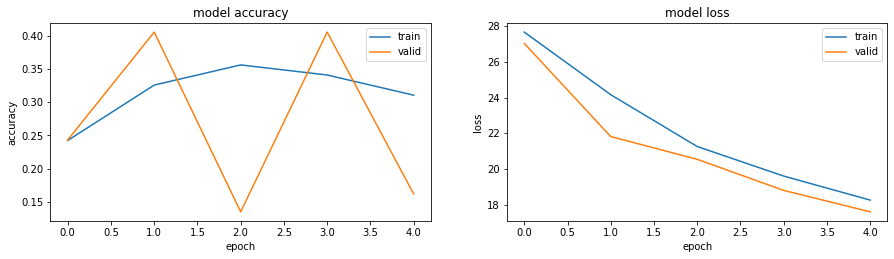


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 3.00e+00 3.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 4.3660 - accuracy: 0.2432

LOSS:	4.36599063873291 	 ACCURACY:	0.2432432472705841
[4.36599063873291, 0.2432432472705841]



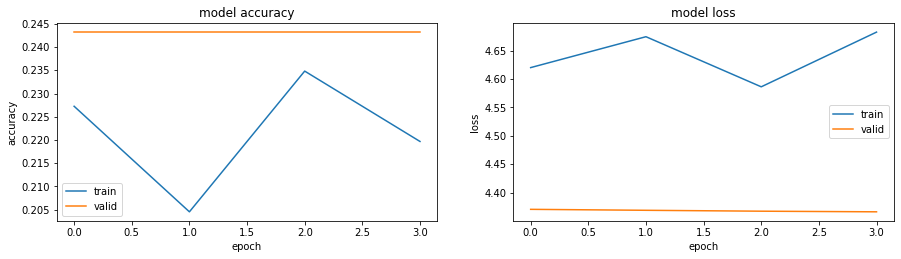


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 1.8791 - accuracy: 0.1892

LOSS:	1.879120111465454 	 ACCURACY:	0.18918919563293457
[1.879120111465454, 0.18918919563293457]



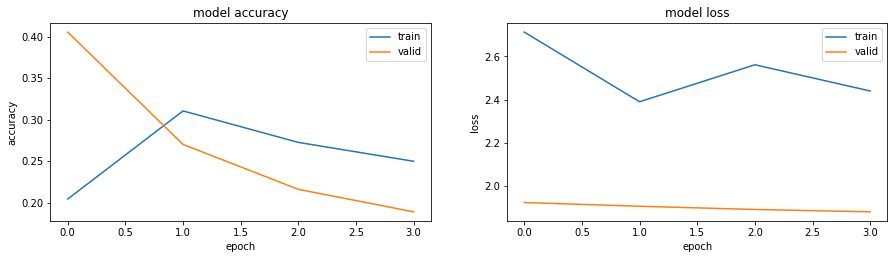


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-02 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 4.3736 - accuracy: 0.2162

LOSS:	4.3736186027526855 	 ACCURACY:	0.21621622145175934
[4.3736186027526855, 0.21621622145175934]



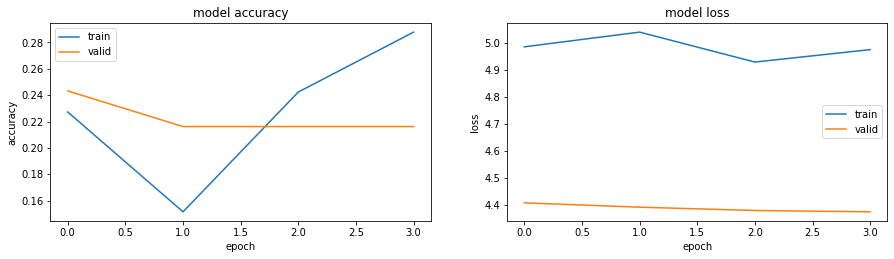


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 1.00e+00 5.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 28.9456 - accuracy: 0.1351

LOSS:	28.945602416992188 	 ACCURACY:	0.13513512909412384
[28.945602416992188, 0.13513512909412384]



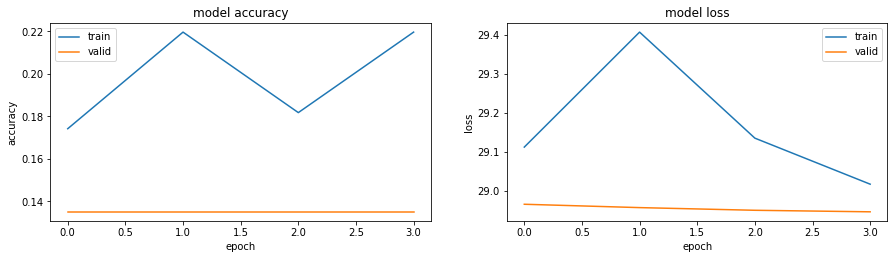


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 1.00e+00 7.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.40541 to 0.54054, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.54054

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.54054

Epoch 6: val_accuracy did not improve from 0.54054
Epoch 6: early stopping
2/2 [==============================] - 0s 28ms/step - loss: 54.7798 - accuracy: 0.5135

LOSS:	54.77982711791992 	 ACCURACY:	0.5135135054588318
[54.77982711791992, 0.5135135054588318]



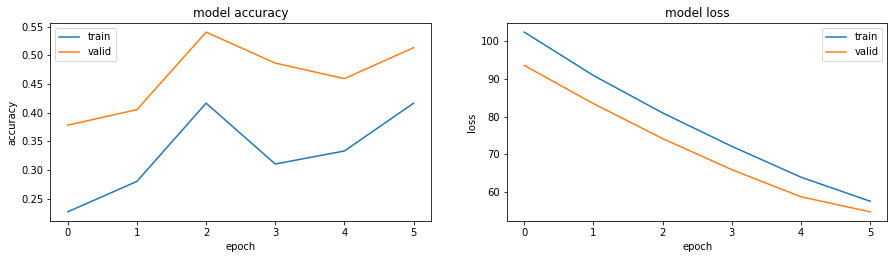


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 4.0245 - accuracy: 0.1351

LOSS:	4.024549961090088 	 ACCURACY:	0.13513512909412384
[4.024549961090088, 0.13513512909412384]



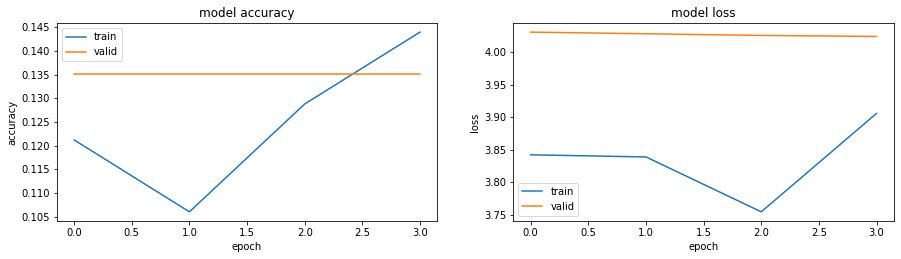


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.35135 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy improved from 0.43243 to 0.48649, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.48649

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.48649

Epoch 7: val_accuracy improved from 0.48649 to 0.54054, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.54054

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.54054

Epoch 10: val_accuracy did not improve from 0.54054
Epoch 10: early stopping
2/2 [====

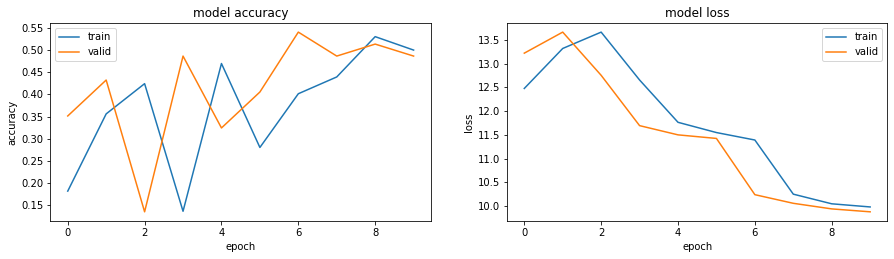


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 15ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.32432, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.32432 to 0.48649, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.48649 to 0.51351, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.51351

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.51351

Epoch 6: val_accuracy did not improve from 0.51351
Epoch 6: early stopping
2/2 [==============================] - 0s 19ms/step - loss: 2.2190 - accuracy: 0.4595

LOSS:	2.21903920173645 	 ACCURACY:	0.45945945382118225
[2.21903920173645, 0.45945945382118225]



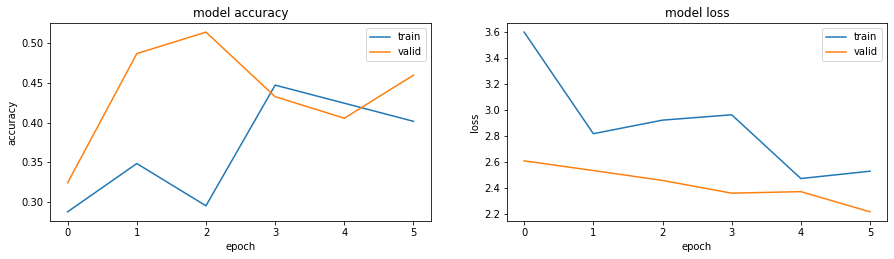


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy improved from 0.24324 to 0.27027, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.27027

Epoch 6: ReduceLROnPlateau reducing learning rate to 3.5999998544866682e-06.

Epoch 6: val_accuracy did not improve from 0.27027

Epoch 7: val_accuracy did not improve from 0.27027
Epoch 7: early stopping
2/2 [==============================] - 0s 25ms/step - loss: 12.0337 - accuracy: 0.2703

LOSS:	12.03368854522705 	 ACCURACY:	0.2702702581882477
[12.03368854522705, 0.2702702581882477]



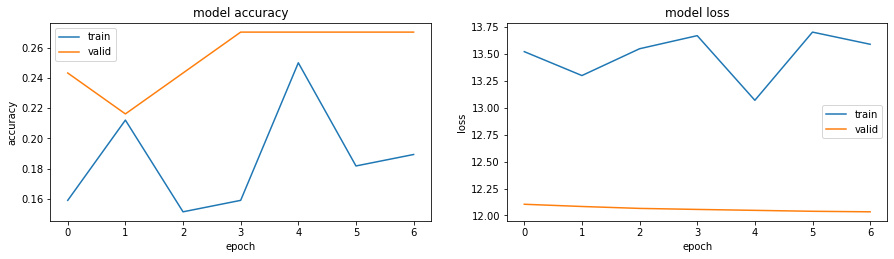


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 17ms/step - loss: 12.3353 - accuracy: 0.1351

LOSS:	12.33526611328125 	 ACCURACY:	0.13513512909412384
[12.33526611328125, 0.13513512909412384]



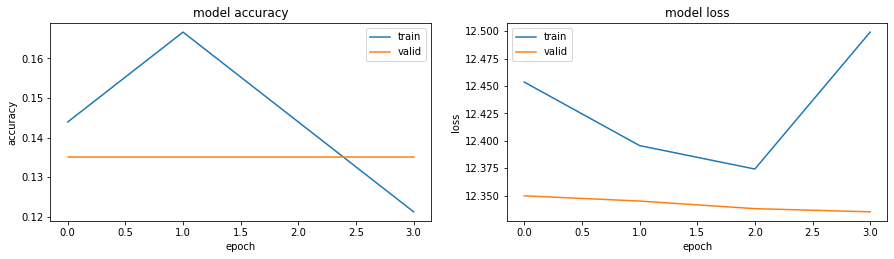


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.48649 to 0.51351, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.51351

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.51351

Epoch 8: val_accuracy did not improve from 0.51351
Epoch 8: early stopping
2/2 [==============================] - 0s 16ms/step - loss: 96.1196 - accuracy: 0.5135

LOSS:	96.1196060180664 	 ACCURACY:	0.5135135054588318
[96.1196060180664, 

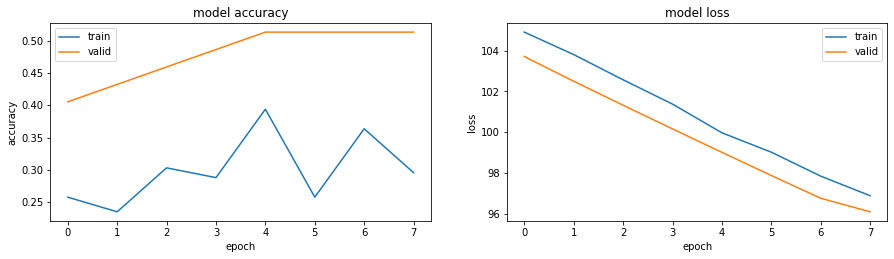


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 1.00e+00 5.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 3.4396 - accuracy: 0.2432

LOSS:	3.4396440982818604 	 ACCURACY:	0.2432432472705841
[3.4396440982818604, 0.2432432472705841]



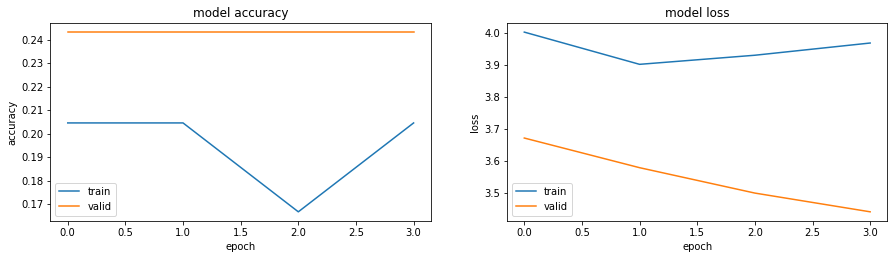


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy improved from 0.43243 to 0.48649, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.48649

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.48649

Epoch 7: val_accuracy did not improve from 0.48649
Epoch 7: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 10.9588 - accuracy: 0.4054

LOSS:	10.958765029907227 	 ACCURACY:	0.4054054021835327
[10.958765029907227, 0.4054054021835327]



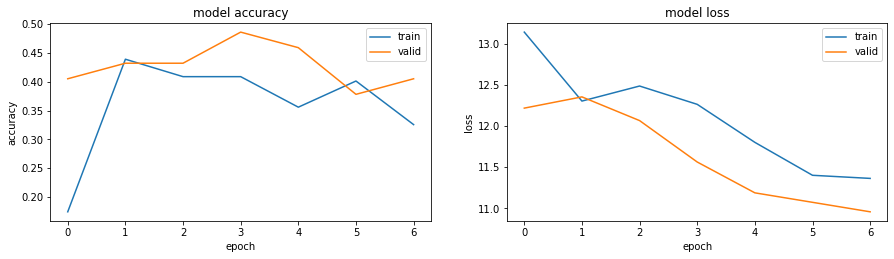


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 14ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy improved from 0.40541 to 0.48649, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.48649

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 6: val_accuracy did not improve from 0.48649

Epoch 7: val_accuracy did not improve from 0.48649
Epoch 7: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 10.9397 - accuracy: 0.4054

LOSS:	10.939661979675293 	 ACCURACY:	0.4054054021835327
[10.939661979675293, 0.4054054021835327]



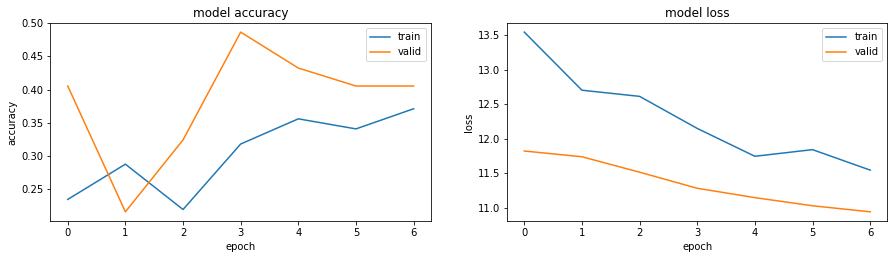


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 2.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: val_accuracy did not improve from 0.21622
Epoch 4: early stopping
2/2 [==============================] - 0s 19ms/step - loss: 105.2127 - accuracy: 0.2162

LOSS:	105.2127456665039 	 ACCURACY:	0.21621622145175934
[105.2127456665039, 0.21621622145175934]



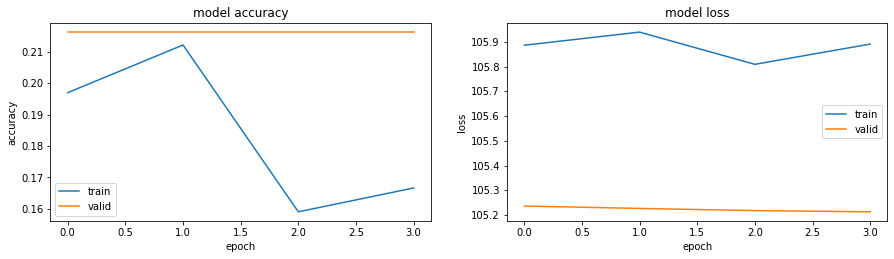


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 14ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.16216 to 0.18919, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.18919 to 0.21622, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.21622 to 0.29730, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.29730 to 0.43243, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.45946

Epoch 8: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.48649 to 0.51351, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.51351 to 0.54054, saving model to VGG_16.h5

Epoch 11: val_accuracy did not 

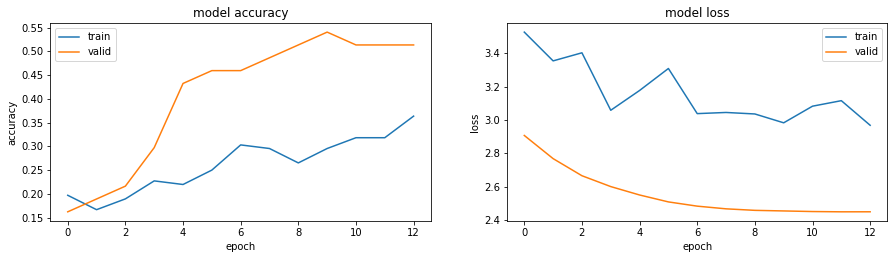


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 7.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 17ms/step - loss: 12.2660 - accuracy: 0.1351

LOSS:	12.266040802001953 	 ACCURACY:	0.13513512909412384
[12.266040802001953, 0.13513512909412384]



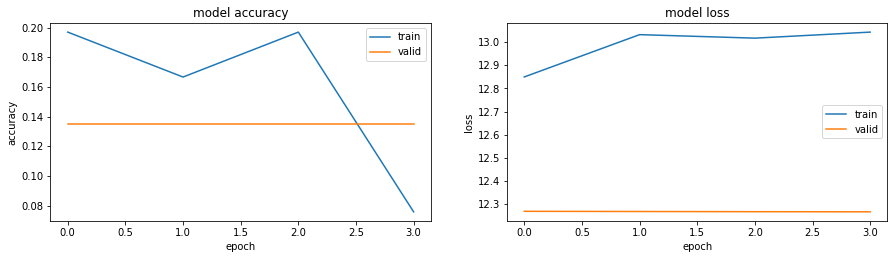


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 2.00e+00 7.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 2.7347 - accuracy: 0.2162

LOSS:	2.734708309173584 	 ACCURACY:	0.21621622145175934
[2.734708309173584, 0.21621622145175934]



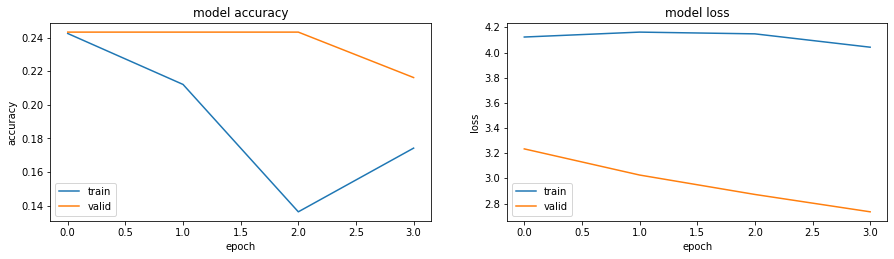


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 7.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: val_accuracy did not improve from 0.21622
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 3.0505 - accuracy: 0.2162

LOSS:	3.0504772663116455 	 ACCURACY:	0.21621622145175934
[3.0504772663116455, 0.21621622145175934]



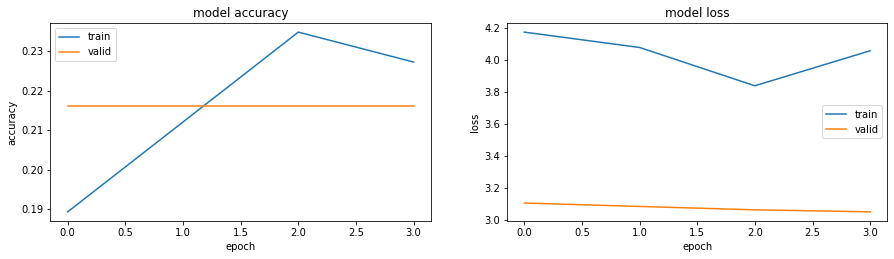


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 15ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.18919 to 0.24324, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.24324 to 0.32432, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.32432 to 0.37838, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.45946

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 9: val_accuracy did not improve from 0.45946

Epoch 10: val_accuracy did not improve from 0.45946
Epoch 10: early s

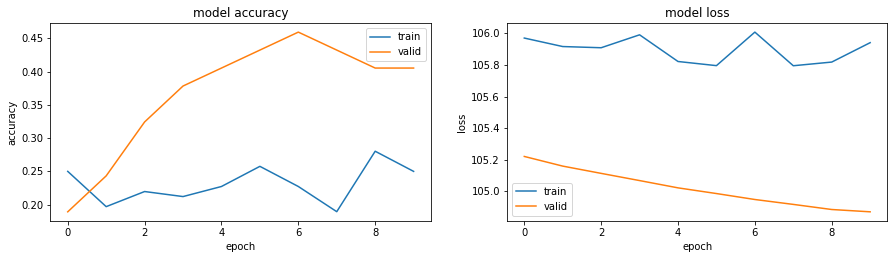


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 5.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 2.5531 - accuracy: 0.3784

LOSS:	2.553102970123291 	 ACCURACY:	0.37837839126586914
[2.553102970123291, 0.37837839126586914]



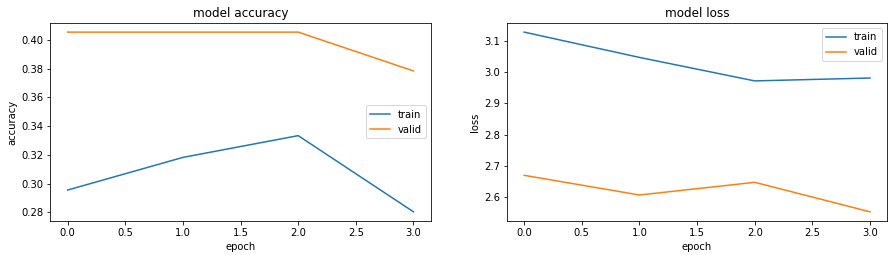


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.27027

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.27027

Epoch 4: val_accuracy did not improve from 0.27027
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 2.5066 - accuracy: 0.2703

LOSS:	2.506556272506714 	 ACCURACY:	0.2702702581882477
[2.506556272506714, 0.2702702581882477]



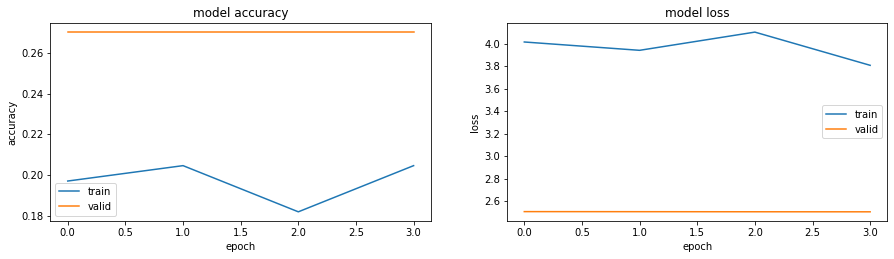


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.24324 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.45946

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.45946

Epoch 8: val_accuracy did not improve from 0.45946
Epoch 8: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 44.7244 - accuracy: 0.4324

LOSS:	44.7243537902832 	 ACCURACY:	0.4324324429035187
[44.7243537902832, 0.4324324429035187]



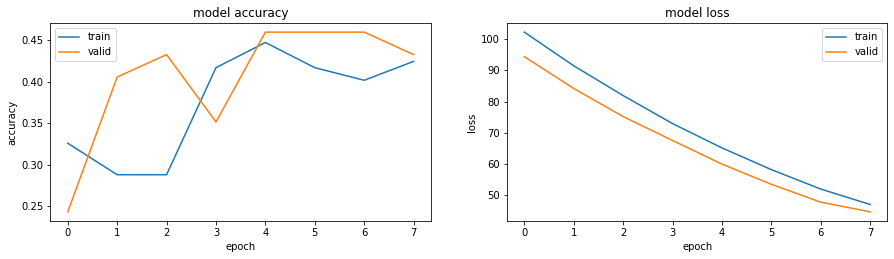


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 3.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: val_accuracy improved from 0.21622 to 0.27027, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.27027 to 0.32432, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.32432

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 6: val_accuracy did not improve from 0.32432

Epoch 7: val_accuracy did not improve from 0.32432
Epoch 7: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 11.8563 - accuracy: 0.2973

LOSS:	11.856305122375488 	 ACCURACY:	0.29729729890823364
[11.856305122375488, 0.29729729890823364]



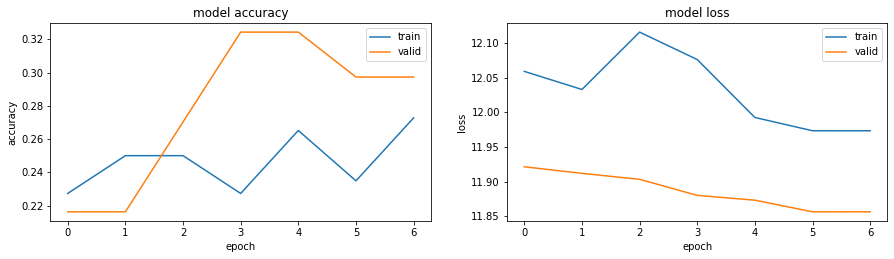


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: val_accuracy did not improve from 0.40541
Epoch 5: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 2.5348 - accuracy: 0.4054

LOSS:	2.534752607345581 	 ACCURACY:	0.4054054021835327
[2.534752607345581, 0.4054054021835327]



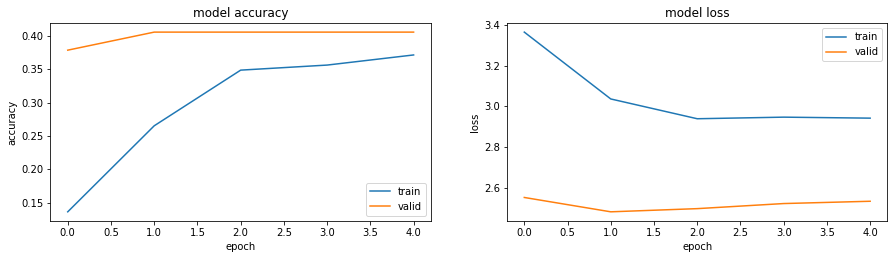


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 3.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 14ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.27027

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.27027

Epoch 4: val_accuracy did not improve from 0.27027
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 2.6968 - accuracy: 0.2703

LOSS:	2.6967995166778564 	 ACCURACY:	0.2702702581882477
[2.6967995166778564, 0.2702702581882477]



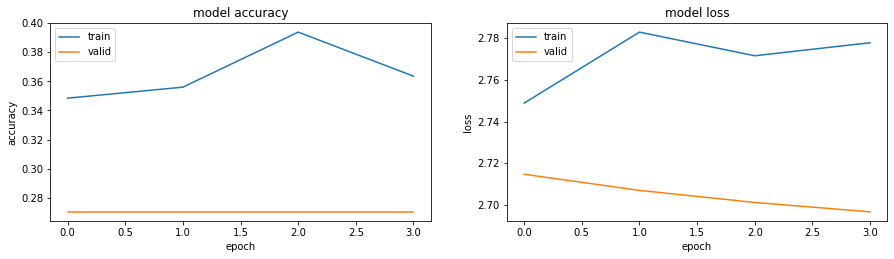


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: val_accuracy improved from 0.08108 to 0.10811, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.10811 to 0.13514, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.13514

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.13514

Epoch 7: val_accuracy did not improve from 0.13514
Epoch 7: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 12.1219 - accuracy: 0.1351

LOSS:	12.121933937072754 	 ACCURACY:	0.13513512909412384
[12.121933937072754, 0.13513512909412384]



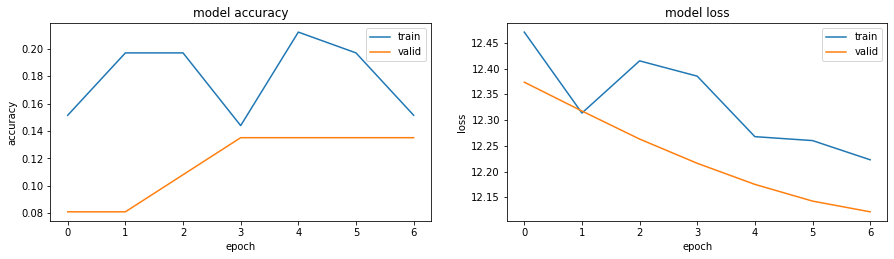


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.13514 to 0.32432, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.32432 to 0.35135, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.35135 to 0.37838, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.40541

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.40541

Epoch 8: val_accuracy did not improve from 0.40541
Epoch 8: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 2.6434 - accuracy: 0.4054

LOSS:	2.643373966217041 	 ACCURACY:	0.4054054021835327
[2.643373966217041

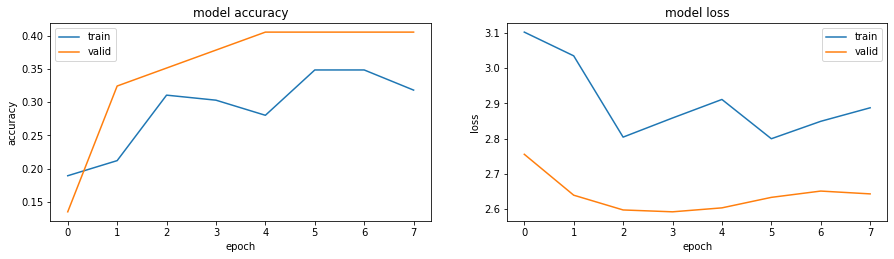


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 18ms/step - loss: 13.5670 - accuracy: 0.1622

LOSS:	13.566953659057617 	 ACCURACY:	0.1621621549129486
[13.566953659057617, 0.1621621549129486]



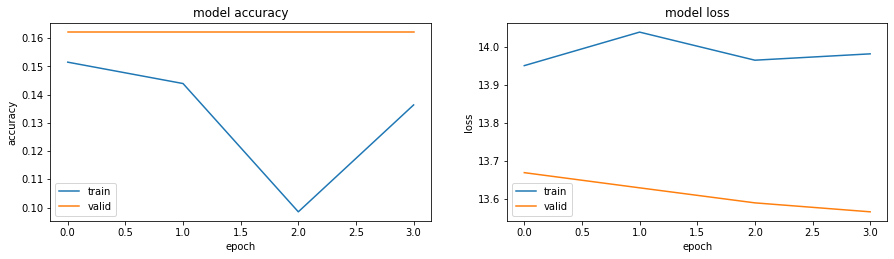


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 1.00e+00 7.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 14ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.27027

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.27027

Epoch 4: val_accuracy improved from 0.27027 to 0.29730, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.29730

Epoch 6: ReduceLROnPlateau reducing learning rate to 3.5999998544866682e-06.

Epoch 6: val_accuracy did not improve from 0.29730

Epoch 7: val_accuracy improved from 0.29730 to 0.32432, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.32432

Epoch 9: ReduceLROnPlateau reducing learning rate to 2.159999939976842e-06.

Epoch 9: val_accuracy did not improve from 0.32432

Epoch 10: val_accuracy did not improve

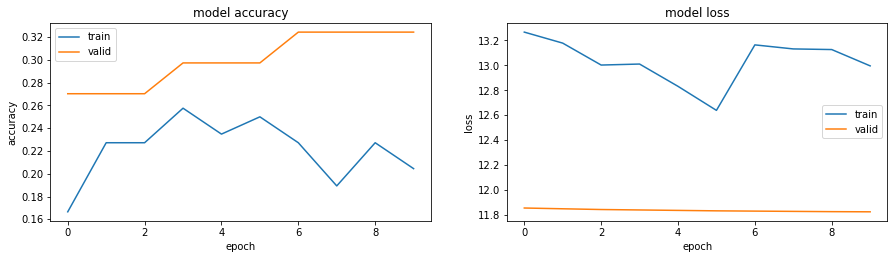


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 2.8570 - accuracy: 0.4054

LOSS:	2.8569679260253906 	 ACCURACY:	0.4054054021835327
[2.8569679260253906, 0.4054054021835327]



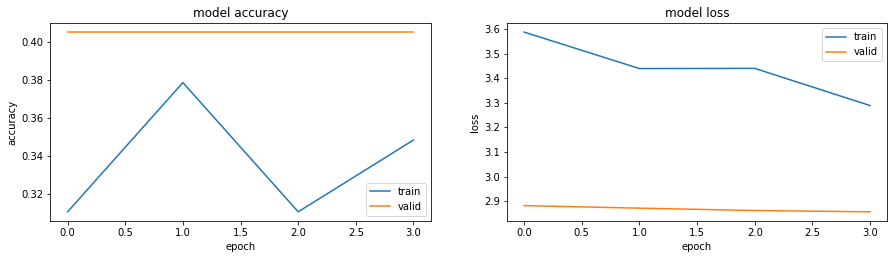


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 104.8061 - accuracy: 0.1892

LOSS:	104.80606079101562 	 ACCURACY:	0.18918919563293457
[104.80606079101562, 0.18918919563293457]



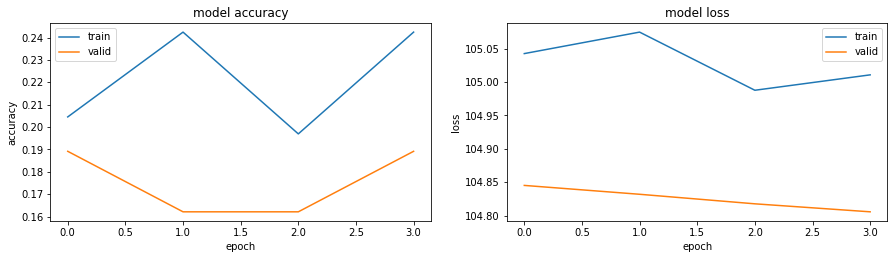


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 12.1458 - accuracy: 0.1351

LOSS:	12.145757675170898 	 ACCURACY:	0.13513512909412384
[12.145757675170898, 0.13513512909412384]



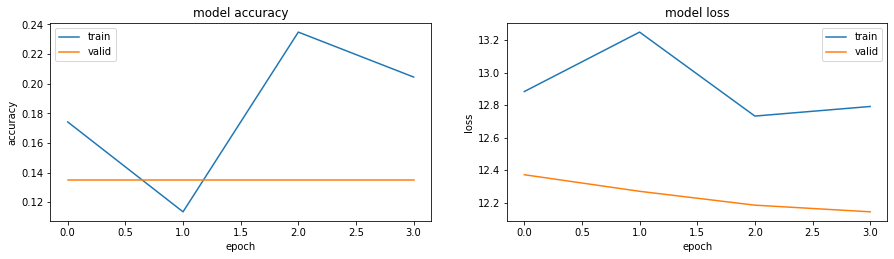


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 104.6780 - accuracy: 0.3784

LOSS:	104.6779556274414 	 ACCURACY:	0.37837839126586914
[104.6779556274414, 0.37837839126586914]



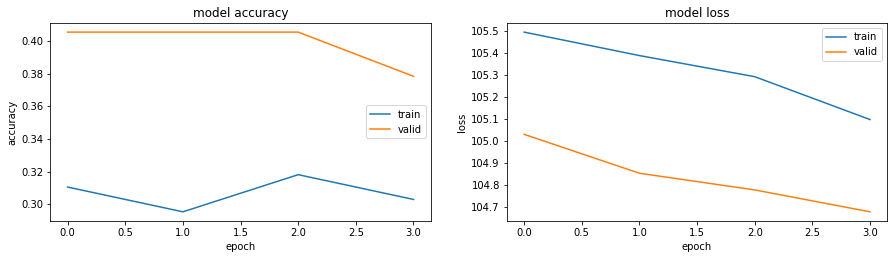


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 7.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 12.0052 - accuracy: 0.4054

LOSS:	12.005160331726074 	 ACCURACY:	0.4054054021835327
[12.005160331726074, 0.4054054021835327]



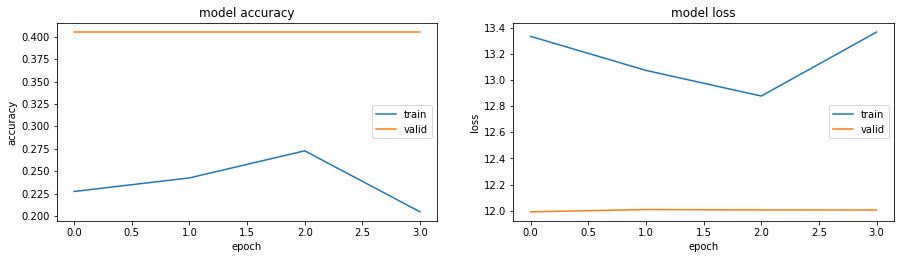


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 2.00e+00 3.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 14ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.37838

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.37838

Epoch 4: val_accuracy did not improve from 0.37838
Epoch 4: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 105.4605 - accuracy: 0.3784

LOSS:	105.46051788330078 	 ACCURACY:	0.37837839126586914
[105.46051788330078, 0.37837839126586914]



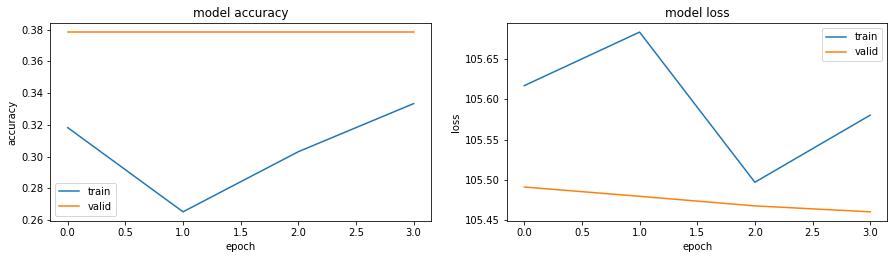


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 3.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 16ms/step - loss: 2.7578 - accuracy: 0.2432

LOSS:	2.757788896560669 	 ACCURACY:	0.2432432472705841
[2.757788896560669, 0.2432432472705841]



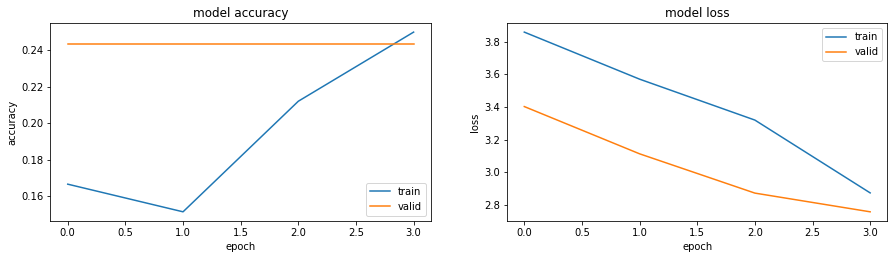


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 7.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 3.5518 - accuracy: 0.1351

LOSS:	3.551765203475952 	 ACCURACY:	0.13513512909412384
[3.551765203475952, 0.13513512909412384]



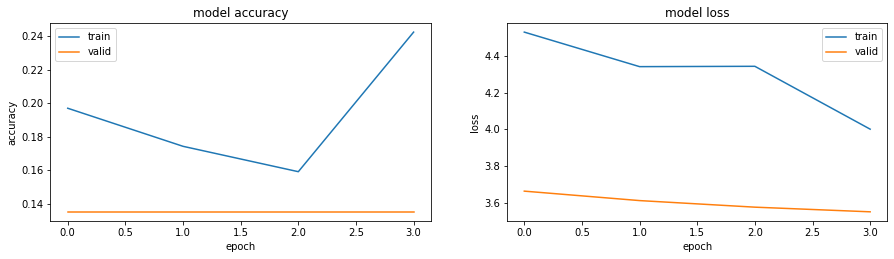


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 105.1889 - accuracy: 0.4054

LOSS:	105.18892669677734 	 ACCURACY:	0.4054054021835327
[105.18892669677734, 0.4054054021835327]



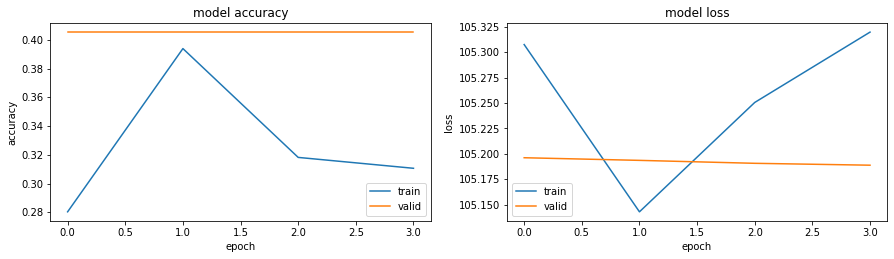


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 3.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.35135

Epoch 3: val_accuracy improved from 0.35135 to 0.40541, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.40541

Epoch 6: val_accuracy did not improve from 0.40541
Epoch 6: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 11.7038 - accuracy: 0.3784

LOSS:	11.703811645507812 	 ACCURACY:	0.37837839126586914
[11.703811645507812, 0.37837839126586914]



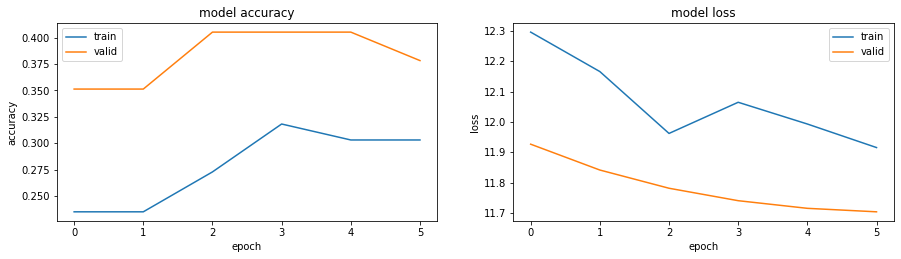


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 3.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 18ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 12.0948 - accuracy: 0.1351

LOSS:	12.094832420349121 	 ACCURACY:	0.13513512909412384
[12.094832420349121, 0.13513512909412384]



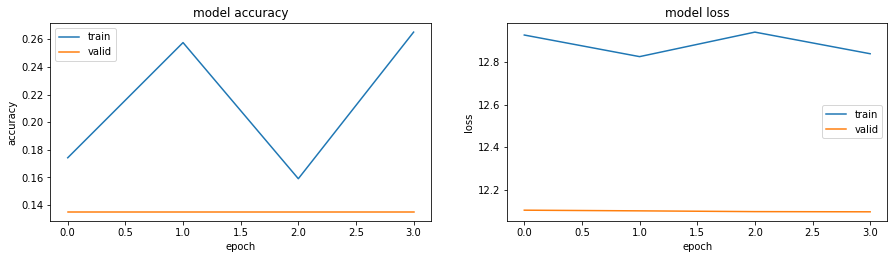


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy improved from 0.08108 to 0.10811, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.10811

Epoch 6: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 6: val_accuracy did not improve from 0.10811

Epoch 7: val_accuracy did not improve from 0.10811
Epoch 7: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 12.7356 - accuracy: 0.1081

LOSS:	12.735629081726074 	 ACCURACY:	0.10810811072587967
[12.735629081726074, 0.10810811072587967]



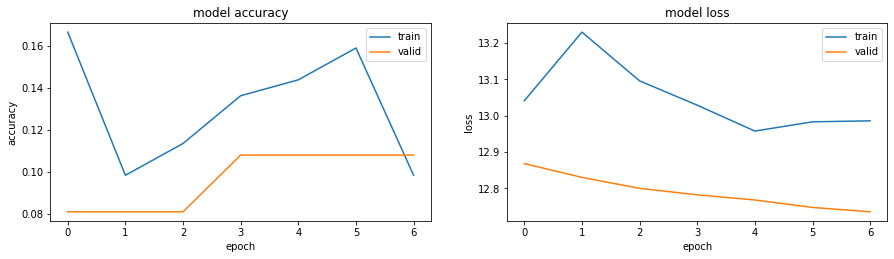


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 3.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 105.3137 - accuracy: 0.4054

LOSS:	105.31369018554688 	 ACCURACY:	0.4054054021835327
[105.31369018554688, 0.4054054021835327]



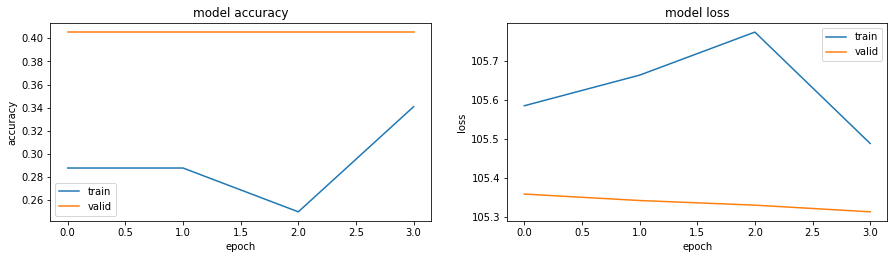


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.05405, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.05405 to 0.27027, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.27027

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.27027

Epoch 5: val_accuracy did not improve from 0.27027
Epoch 5: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 104.1847 - accuracy: 0.2703

LOSS:	104.18472290039062 	 ACCURACY:	0.2702702581882477
[104.18472290039062, 0.2702702581882477]



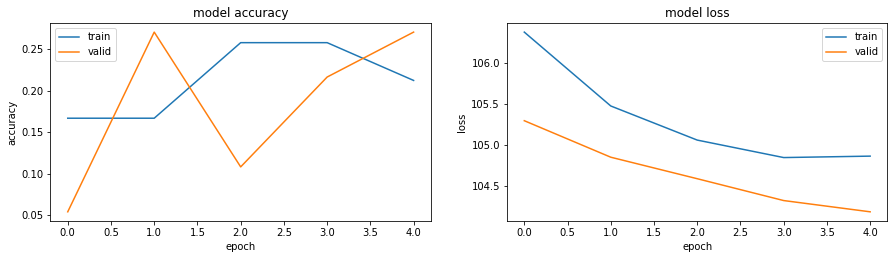


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 2.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 105.2747 - accuracy: 0.2162

LOSS:	105.2746810913086 	 ACCURACY:	0.21621622145175934
[105.2746810913086, 0.21621622145175934]



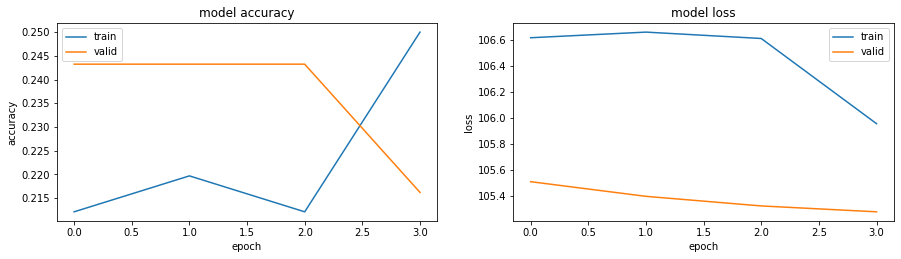


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 105.6726 - accuracy: 0.1892

LOSS:	105.67259979248047 	 ACCURACY:	0.18918919563293457
[105.67259979248047, 0.18918919563293457]



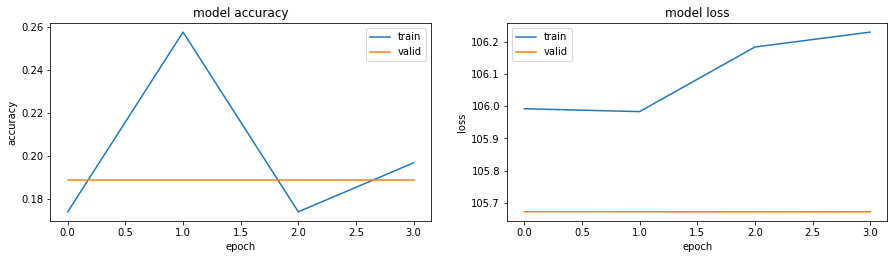


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 7.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.35135 to 0.37838, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.40541

Epoch 6: val_accuracy did not improve from 0.40541
Epoch 6: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 102.1154 - accuracy: 0.4054

LOSS:	102.11541748046875 	 ACCURACY:	0.4054054021835327
[102.11541748046875, 0.4054054021835327]



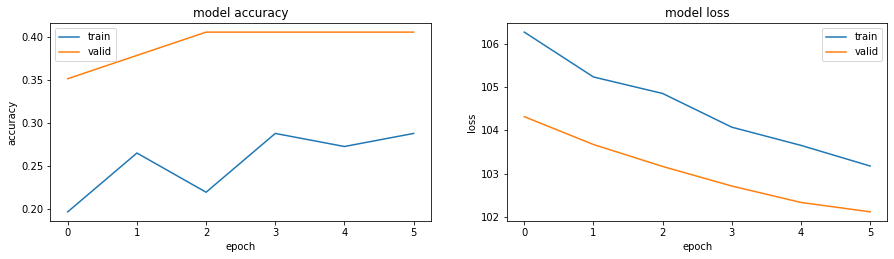


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 3.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 15ms/step - loss: 11.5610 - accuracy: 0.4054

LOSS:	11.561003684997559 	 ACCURACY:	0.4054054021835327
[11.561003684997559, 0.4054054021835327]



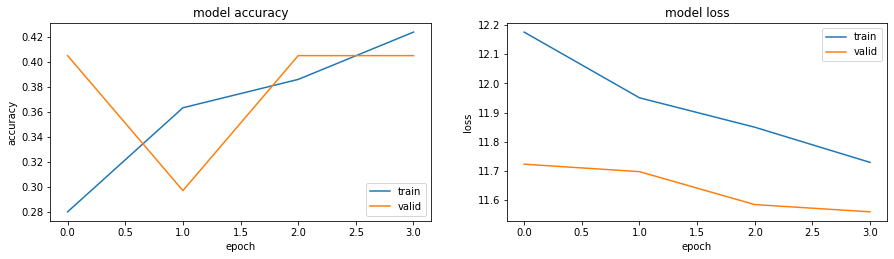


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 17ms/step - loss: 60.0255 - accuracy: 0.2703

LOSS:	60.025535583496094 	 ACCURACY:	0.2702702581882477
[60.025535583496094, 0.2702702581882477]



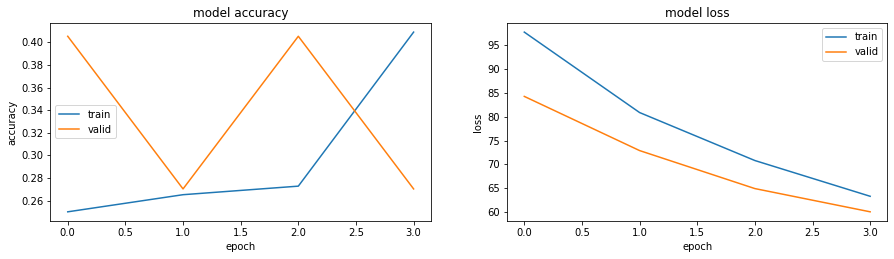


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.21622 to 0.24324, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.24324 to 0.29730, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.29730

Epoch 5: val_accuracy improved from 0.29730 to 0.32432, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.32432 to 0.40541, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.40541

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 8: val_accuracy did not improve from 0.40541

Epoch 9: val_accuracy did not improve from 0.40541
Epoch 9: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 2.5089 - accuracy: 0.4054

LOSS:	2.508881807327270

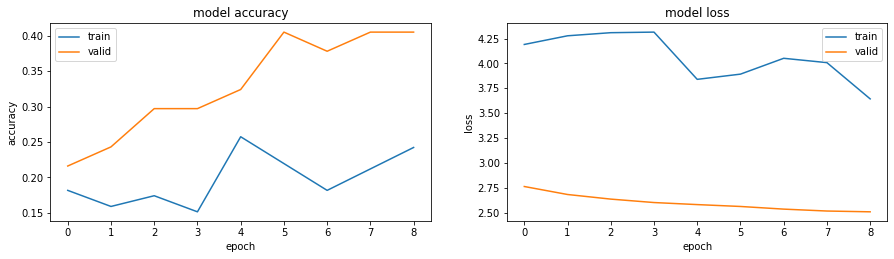


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 1.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 12.2249 - accuracy: 0.1622

LOSS:	12.224908828735352 	 ACCURACY:	0.1621621549129486
[12.224908828735352, 0.1621621549129486]



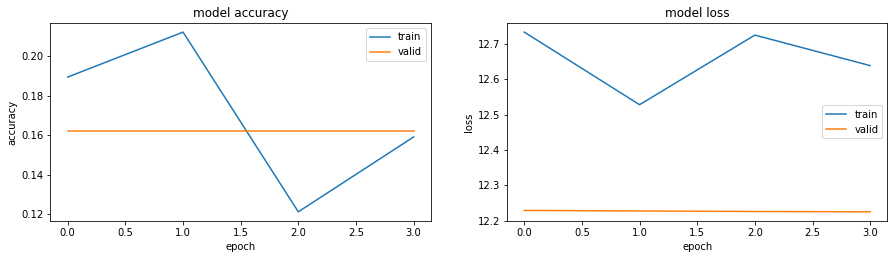


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy improved from 0.16216 to 0.18919, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.18919

Epoch 6: val_accuracy improved from 0.18919 to 0.21622, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.21622

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.5999998544866682e-06.

Epoch 8: val_accuracy did not improve from 0.21622

Epoch 9: val_accuracy did not improve from 0.21622
Epoch 9: early stopping
2/2 [==============================] - 0s 17ms/step - loss: 105.4403 - accuracy: 0.2162

LOSS

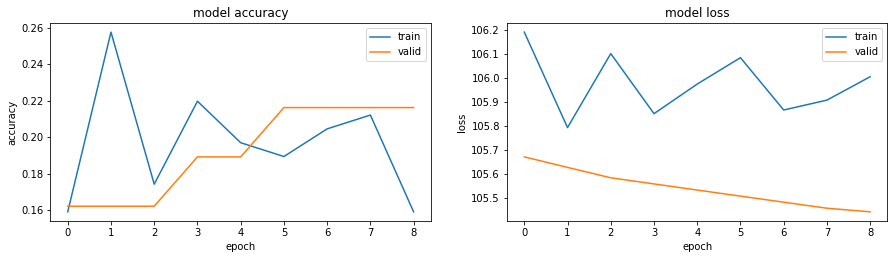


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 26ms/step - loss: 3.2059 - accuracy: 0.1351

LOSS:	3.2059144973754883 	 ACCURACY:	0.13513512909412384
[3.2059144973754883, 0.13513512909412384]



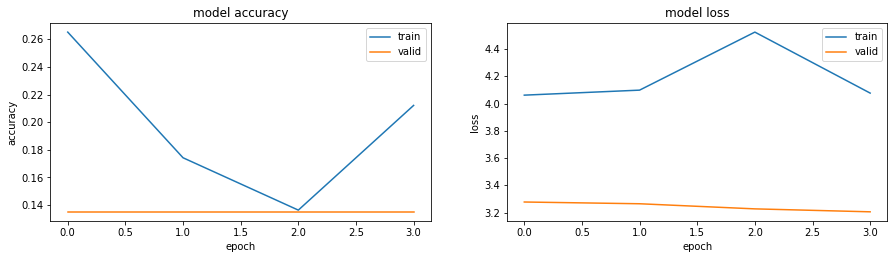


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 1.00e+00 5.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 105.8649 - accuracy: 0.1351

LOSS:	105.8648681640625 	 ACCURACY:	0.13513512909412384
[105.8648681640625, 0.13513512909412384]



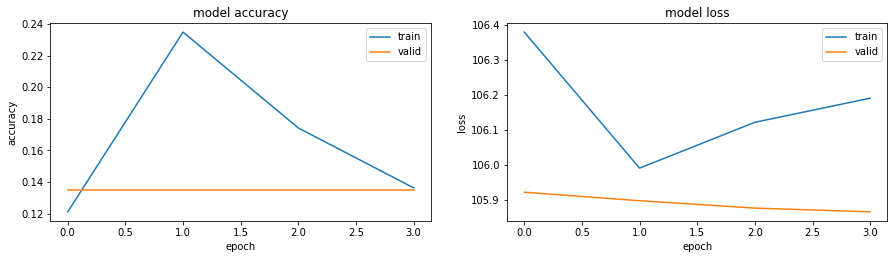


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 1.5250 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.54054, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.54054

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.54054

Epoch 4: val_accuracy did not improve from 0.54054
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 104.6120 - accuracy: 0.5405

LOSS:	104.61198425292969 	 ACCURACY:	0.5405405163764954
[104.61198425292969, 0.5405405163764954]



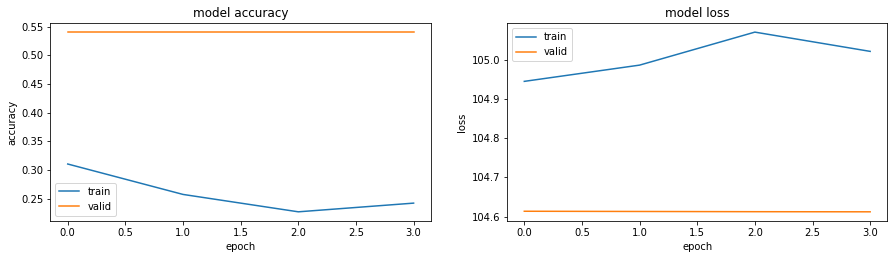


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 1.00e+00 5.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 104.6120 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.18919 to 0.21622, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.21622 to 0.24324, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.24324

Epoch 5: val_accuracy improved from 0.24324 to 0.29730, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.29730

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 7: val_accuracy did not improve from 0.29730

Epoch 8: val_accuracy did not improve from 0.29730
Epoch 8: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 103.8837 - accuracy: 0.2703

LOSS:	103.88368225097656 	 ACCURACY:	0.2702702581882477
[103.88368225097656, 0.2702702581882477]



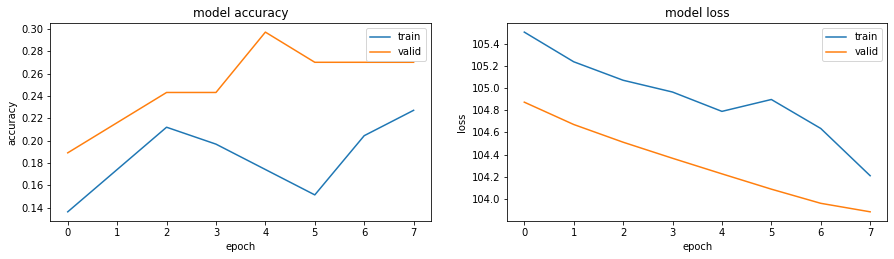


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 104.6120 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.43243

Epoch 3: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.48649 to 0.51351, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.51351

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.51351

Epoch 8: val_accuracy did not improve from 0.51351
Epoch 8: early stopping
2/2 [==============================] - 0s 15ms/step - loss: 2.3945 - accuracy: 0.4595

LOSS:	2.39446759223938 	 ACCURACY:	0.45945945382118225
[2.39446759223938, 0.45945945382118225]



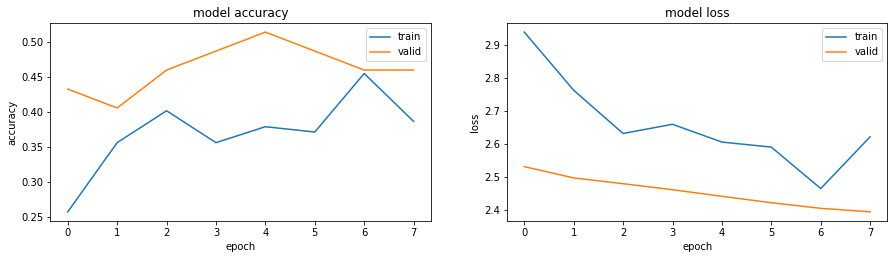


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 104.6120 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.43243

Epoch 6: val_accuracy improved from 0.43243 to 0.48649, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.48649 to 0.54054, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.54054

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 9: val_accuracy did not improve from 0.54054

Epoch 10: val_accuracy did not improve from 0.54054


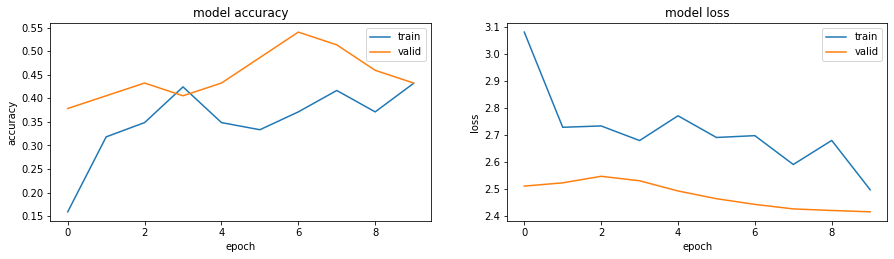

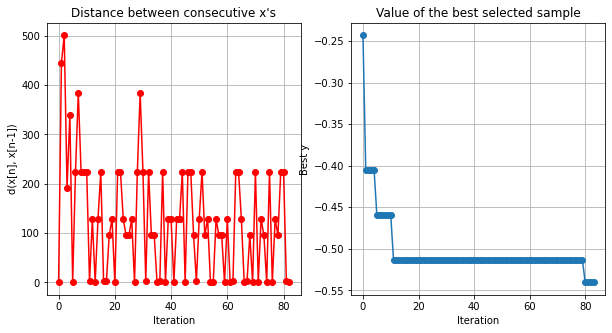

In [12]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)},
          {'name': 'optim', 'type': 'discrete', 'domain': (1, 2, 3)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# Note: 'optim' domain parameters (1, 2, 3) correspond to strings ('Adam', 'SGD', 'RMSprop'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('VGG_16_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]),
                                        optim=int(x[:,6]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],
  evaluation[1]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=100, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [14]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]),
           bounds[6]["name"], optimizer_dict[optimizer.x_opt[6]])
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	512.0
	learning_rate:	1e-05
	l2:	0.1
	activation:	tanh
	rate:	0.5
	batch:	256.0
 optim SGD
optimized accuracy: [0.54054052]


In [15]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('VGG_16_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 265,221
Trainable params: 265,221
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 26ms/step - loss: 104.6120 - accuracy: 0.5405
Restored model, accuracy: 54.05%


In [16]:
best_model.evaluate(features_valid, y_test)

2/2 [==============================] - 0s 18ms/step - loss: 104.6120 - accuracy: 0.5405


[104.61198425292969, 0.5405405163764954]

In [17]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Sat May 28 12:38:06 2022
Optimization completed:      NO,84 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           212.11907982826233 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           7
Number continuous variables  0
Number discrete variables    7
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition op

Test model with test data

In [18]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [20]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for test set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

In [21]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

1/1 [==============================] - 0s 87ms/step - loss: 104.7167 - accuracy: 0.3333
Restored model, accuracy: 33.33%


In [22]:
best_model.evaluate(features_test, y_test)

1/1 [==============================] - 0s 45ms/step - loss: 104.7167 - accuracy: 0.3333


[104.71668243408203, 0.3333333432674408]